# Optimizing Model - Creating Average Departure and Arrival Delays

In [ ]:
## Model Iteration 2
## Feature Eng: Average departure and arrival delays by flight number (route)  
## Purpose: To measure uplift of adding the average departure and arrival delays by route
## Results : 
##      LightGBM Model RMSE is:  42.00756954088724 (1.13% change)
##      LightGBM Model R2 Score is:  0.06256947947856017 (-5.92% change)
##      LightGBM Model Cross-validation MAE is: 23.33587061291061 (0.38% change)
##      XGBoostModel RMSE is:  42.17275006580812 (-1.00% change)
##      XGBoost Model R2 Score is:  0.055182729642471395 (67.34% change)
##      XGBoost Model Cross-validation MAE is: 22.429796 (-0.79% change)

In [ ]:
Model RMSE is:  42.17275006580812
Model R2 Score is:  0.055182729642471395

In [59]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [60]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_01.csv', sep = ',')

In [61]:
df_flight_info = data_flight_info.copy()

In [62]:
df_flight_info.tail()

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,crs_dep_time,dep_time,dep_delay,dest,arr_time,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,month,day,weekday
578883,2019-04-12,AS,AS,1039,LAS,600,558.0,-2.0,SEA,915.0,...,867.0,0.0,0.0,25.0,0.0,0.0,2019,4,12,0.0
578884,2019-03-27,UA,OO,5744,LAX,2240,2307.0,27.0,SBA,4.0,...,89.0,0.0,0.0,2.0,0.0,27.0,2019,3,27,0.0
578885,2018-08-13,AA,AA,588,LGA,559,558.0,-1.0,PHL,714.0,...,96.0,0.0,0.0,0.0,0.0,0.0,2018,8,13,0.0
578886,2018-07-13,UA,UA,1027,ORD,1425,1421.0,-4.0,CHS,1744.0,...,760.0,0.0,0.0,0.0,0.0,0.0,2018,7,13,0.0
578887,2018-02-23,AA,OO,3099,ORD,950,946.0,-4.0,CID,1104.0,...,196.0,0.0,0.0,0.0,0.0,0.0,2018,2,23,0.0


In [63]:
## Grouping Delays

# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [64]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]

In [65]:
# Getting Average NAS Delay - Grouped by Flight Number
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number', 'total_nas_delay']]


# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped[['origin','total_security_delay']]

# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(carrier_grouped, on = 'op_unique_carrier', how = 'outer')

## Model Training

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [67]:
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [68]:
df_flight_info.head(1)

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,crs_dep_time,dep_time,dep_delay,dest,arr_time,...,month,day,weekday,flight_number,total_security_delay,total_nas_delay,average_route_time,total_dep_delay,total_arr_delay,total_carrier_delay
0,2018-03-06,B6,B6,112,ORD,2033,2016.0,-17.0,BOS,2340.0,...,3,6,0.0,5279,0.003733,7.275,138.575,50.375,49.575,14.943584


In [69]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','average_route_time','crs_arr_time','distance','total_carrier_delay', 'total_security_delay','total_nas_delay','total_dep_delay','total_arr_delay']]
y = df_flight_info['arr_delay']

In [70]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [71]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 405221, number of used features: 11
[LightGBM] [Info] Start training from score 5.637632
Model RMSE is:  42.00756954088724
Model R2 Score is:  0.06256947947856017


In [72]:
# Cross-validate
cv_results = lgb.cv(
        params,
        d_train,
        num_boost_round=100,
        nfold=3,
        metrics='mae',
        early_stopping_rounds=10,

        stratified=False
        )
# Display results
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['l1-mean']))
print('LightGBM Model Cross-validation MAE is:', cv_results['l1-mean'][-1])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 270146, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Number of data points in the train set: 270146, number of used features: 11
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2336
[LightGBM] [Info] Numbe

##### XGBoost

In [73]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  42.17275006580812
Model R2 Score is:  0.055182729642471395


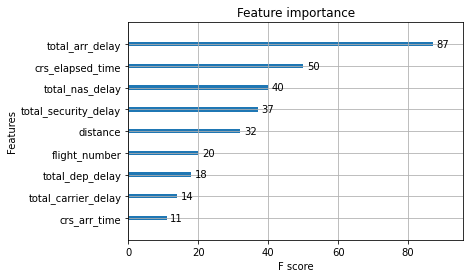

In [74]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

In [75]:
params = {'objective':'reg:squarederror', 'colsample_bytree' : 0.3, 'learning_rate' : 0.1,
                'max_depth' : 5, 'alpha' : 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="mae", as_pandas=True, seed=123)

print('XGBoost Model Cross-validation MAE is: ',(cv_results["test-mae-mean"]).tail(1))

XGBoost Model Cross-validation MAE is:  0    22.429796
Name: test-mae-mean, dtype: float64


##### Linear Regression

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  41.490923020272554
Model R2 Score is:  0.0716483738438426


In [77]:
from numpy import mean
from numpy import absolute

#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = lr

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Linear Model Cross-validation MAE is: ',mean(absolute(scores)))

Linear Model Cross-validation MAE is:  23.38332334800338


##### Ridge/Lasso Regression

In [78]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Ridge Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Ridge Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Lasso Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Lasso Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Ridge Model RMSE is:  41.491040679390345
Ridge Model R2 Score is:  0.07164310863496048
Lasso Model RMSE is:  41.49959040222163
Lasso Model R2 Score is:  0.07126047123872425


In [79]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple ridge regression model
model = ridgereg

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Ridge Model Cross-validation MAE is: ',mean(absolute(scores)))

#build multiple lassp regression model
model = lassoreg

#use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

#view mean absolute error
print('Lasso Model Cross-validation MAE is: ',mean(absolute(scores)))

Ridge Model Cross-validation MAE is:  23.382951967825303
Lasso Model Cross-validation MAE is:  23.363186076422625


##### Random Forest

In [18]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators=100)

In [19]:
#Train the model using the training sets 
clf.fit(X_train,y_train)

RandomForestRegressor()

In [20]:
y_pred=clf.predict(X_test)

In [21]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))

Model RMSE is:  48.19745755730411
Model R2 Score is:  -0.20881541977450402
